In [ ]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd 
import scipy as sp 
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, r2_score, accuracy_score 
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score, auc
import statsmodels.api as sm 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family = 'Malgun Gothic')

## 1. data load & split

In [ ]:
### data load 
breast_cancer = load_breast_cancer()

### 타겟값 기존에 정상 : 1, 암 : 0
### 타겟값 기존에 암 : 1, 정상 : 0 으로 변경
breast_cancer.target = np.where(breast_cancer.target == 0,1,0) ### target값이 0 이면 1로 아니면 0으로 바꾸기 np.where(condition, true input, false input)

### train test split
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size = 0.3, random_state = 2021)

## 2. preprocessing

In [ ]:
### preprocessing
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test) ### fitting 없이 transform

## 3. modeling

In [ ]:
### modeling
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## 4. Analysis 

### 4.1 logistic regression coefficient (Feature importance) : 베타 값으로 독립변수의 영향력 확인

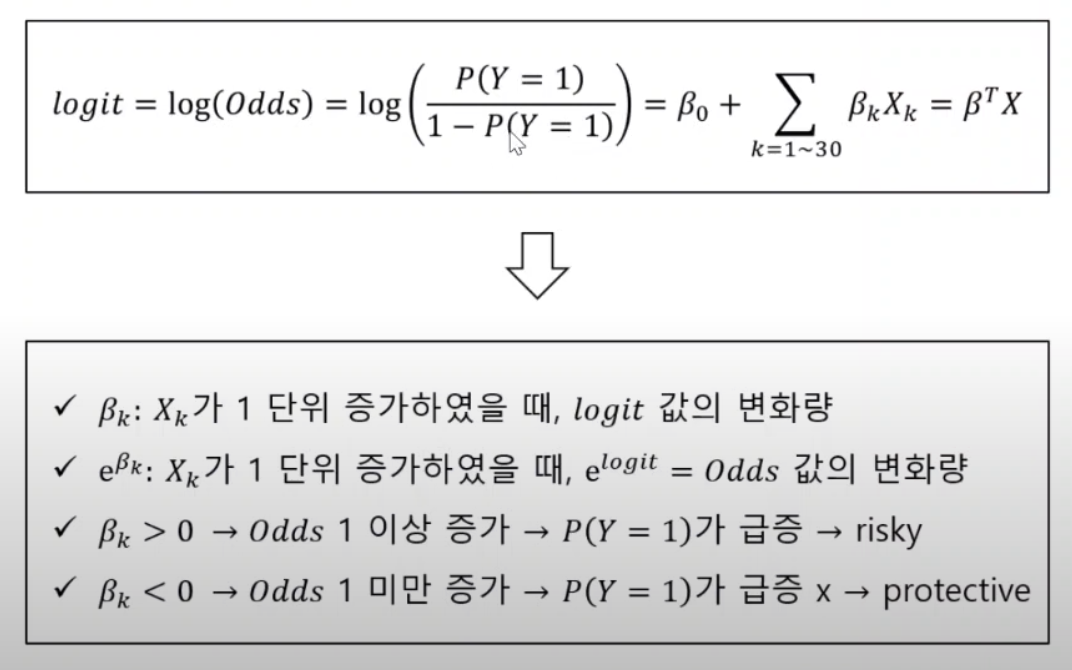

In [ ]:
column_name = ['const'] + breast_cancer.feature_names.tolist()

## 베타 값 추출 : logit 값의 변화량 - feature importance의 역할을 함 
beta = np.concatenate([model.intercept_, model.coef_.reshape(-1)]).round(2) # 베타0 값, 베타1,2,3,4... 값들 concat 

## exp(베타) 값 추출 : odd 값의 변화량
odds = np.exp(beta).round(2) 

## 베타 값 해석 : 0보다 크면 risky, 0보다 작으면 protective
interpret = np.where(beta>0, 'risky', 'protective')
beta_analysis = pd.DataFrame(np.c_[beta, odds, interpret], index = column_name, columns = ['beta', 'exp(beta)','interpret'])
beta_analysis.sort_values(by = 'exp(beta)', ascending = False)

,beta,exp(beta),interpret
worst texture,1.16,3.19,risky
worst symmetry,1.1,3.0,risky
radius error,1.09,2.97,risky
worst smoothness,1.01,2.75,risky
worst concave points,0.99,2.69,risky
mean concavity,0.93,2.53,risky
mean texture,0.92,2.51,risky
area error,0.87,2.39,risky
perimeter error,0.81,2.25,risky
worst radius,0.78,2.18,risky


## 5. Evaluation

### 5.1 ROC curve로 Threshold 값 구하기

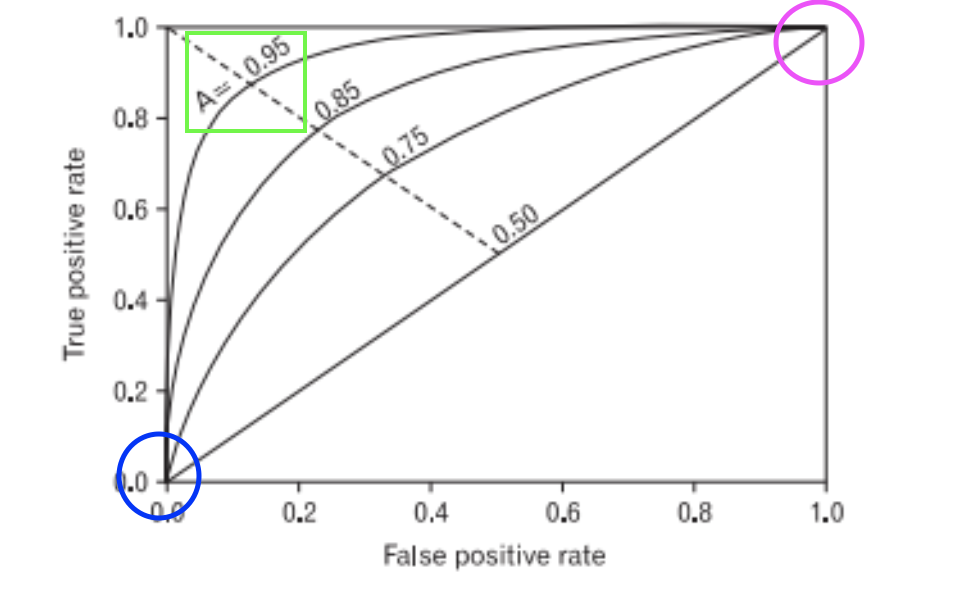

* 재현율과 1- 특이도 의 곡선을 그린 것 
* TPR : True Positive Rate ( = 재현율, true accept rate)
양성인 케이스에 대해 양성으로 잘 예측한 비율.(암환자를 진찰해서 암이라고 진단 함)


* FPR (=1 - TNR) False Positive Rate ( = 1-특이도, false accept rate)
음성인 케이스에 대해 양성으로 잘못 예측한 비율.(암환자가 아닌데 암이라고 진단 함)

* 분홍색 point : 재현율, 1- 특이도 둘다 높은 경우 

    TPR 과 FPR 동시에 높은건 모든 값들이 양성으로 쏠렸다는 이야기

* 파랑색 point : 재현율, 1- 특이도 둘다 낮은 경우 
    
    TPR 과 FPR 동시에 낮은건 모든 값들이 음성으로 쏠렸다는 이야기


* 연두색 point : TPR이 높으면서 1-TNR이 낮은 (재현율, 특이도 모두 높은) 지점인  연두색이 가장 이상적인 수치이다.

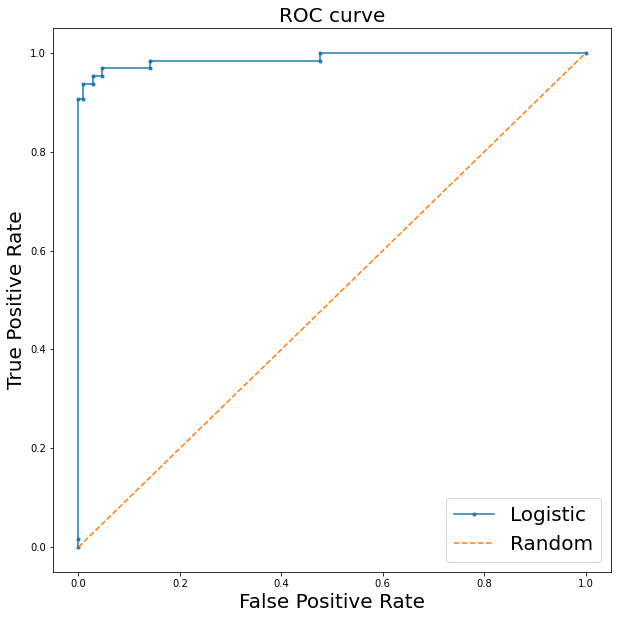



 ROC AUC score :  0.9889018691588787


 ROC Table : 


,FPR,TPR,Threshold
0,0.000000,0.000000,2.00
1,0.000000,0.015625,1.00
2,0.000000,0.906250,0.81
3,0.009346,0.906250,0.77
4,0.009346,0.937500,0.55
5,0.028037,0.937500,0.45
6,0.028037,0.953125,0.39
7,0.046729,0.953125,0.27
8,0.046729,0.968750,0.26
9,0.140187,0.968750,0.06


In [ ]:
### ROC curve

### roc curve 패키지로 fpr, tpr 뽑기
probs = model.predict_proba(X_test)[:,1]
model_fpr, model_tpr, threshold1 = roc_curve(y_test, probs)

### 랜덤하게 했을때는 fpr, tpr 모두 0.5, 0.5로 나온다. 
random_fpr, random_tpr, threshold2 = roc_curve(y_test, [0 for i in range(len(X_test))]) 

plt.figure(figsize = (10,10))
plt.plot(model_fpr, model_tpr, marker = '.', label = "Logistic")
plt.plot(random_fpr, random_tpr, linestyle = '--', label = "Random")

plt.xlabel("False Positive Rate", size = 20)
plt.ylabel("True Positive Rate", size = 20)

plt.legend(fontsize = 20)

plt.title("ROC curve", size = 20)
plt.show()


### AUC 값 확인하기 (ROC curve 아래 부분 면적)
roc_auc = auc(model_fpr, model_tpr)
print("\n\n ROC AUC score : ", roc_auc)


#### ROC data frame
model_fpr, model_tpr, threshold1 = roc_curve(y_test, probs) # threasholds의 갯수는 최소한 predict 확률의 unique한 갯수 + 1만큼 만들어 집니다.
roc_df = pd.DataFrame(roc_curve(y_test, probs)).T
roc_df.columns = ['FPR','TPR','Threshold']
roc_df['Threshold'] = roc_df['Threshold'].round(2)
print("\n\n ROC Table : ")
display(roc_df)

* 위의 ROC table 에서 FPR 값은 낮으면서 동시에 TPR 값이 높은게 이상적임
* 이때의 Threshold 값을 기준으로 예측 시행 (index 2~8까지)

### 5.2 선택된 Threshold 값으로 정확도, 민감도, 정밀도 확인

In [ ]:
selected_threshold = roc_df['Threshold'].iloc[2:9].values ## roc table에서 인덱스 2~8 데이터만 추려냄
P_1 = model.predict_proba(X_test)[:,1] ### 1 유방암 확률 만 추려내기

for input_threshold in selected_threshold:
    y_pred = np.where(P_1.reshape(-1) >= input_threshold, 1, 0) ## cutoff보다 크면 1(유방암), 아니면 0(정상)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    print(f"정확도 : {acc:0.2f}",f"민감도 : {recall:0.2f}",f"정밀도 : {precision:0.2f}", f"cutoff : {input_threshold:0.2f}", f"AUC : {auc}", sep = "  | ")
    # ㅔ갸ㅜ
    display(pd.DataFrame(confusion_matrix(y_test, y_pred)))
    print("====================================")

정확도 : 0.96  | 민감도 : 0.89  | 정밀도 : 1.00  | cutoff : 0.81


,0,1
0,107,0
1,7,57


정확도 : 0.96  | 민감도 : 0.91  | 정밀도 : 1.00  | cutoff : 0.77


,0,1
0,107,0
1,6,58


정확도 : 0.97  | 민감도 : 0.94  | 정밀도 : 0.98  | cutoff : 0.55


,0,1
0,106,1
1,4,60


정확도 : 0.96  | 민감도 : 0.94  | 정밀도 : 0.95  | cutoff : 0.45


,0,1
0,104,3
1,4,60


정확도 : 0.96  | 민감도 : 0.95  | 정밀도 : 0.95  | cutoff : 0.39


,0,1
0,104,3
1,3,61


정확도 : 0.96  | 민감도 : 0.95  | 정밀도 : 0.94  | cutoff : 0.27


,0,1
0,103,4
1,3,61


정확도 : 0.95  | 민감도 : 0.95  | 정밀도 : 0.92  | cutoff : 0.26


,0,1
0,102,5
1,3,61


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
